# Atualização do tccfinal.ipynb com correções e melhores práticas

## 0. Instalação de Bibliotecas (Se necessário)

Certifique-se de que o TensorFlow está instalado no seu ambiente. Se não estiver, execute a célula abaixo:

In [1]:
%pip install tensorflow matplotlib pandas numpy scipy

Note: you may need to restart the kernel to use updated packages.


## 1. Importar Bibliotecas Necessárias

In [2]:

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import os

## 2. Hiperparâmetros e Configuração

In [3]:
NUM_RUNS = 3      # Número de execuções para significância estatística
EPOCHS = 50       # Número original de épocas
PATIENCE = 5      # Paciência para Early Stopping
BATCH_SIZE = 32   # Tamanho do lote
L2_FACTOR = 0.001 # Fator de regularização L2
DROPOUT_RATE = 0.5 # Taxa de Dropout
LEARNING_RATE = 0.001 # Taxa de aprendizado

## 3. Carregamento e Pré-processamento do Dataset CIFAR-10

In [4]:
(x_train_full, y_train_full), (x_test, y_test) = datasets.cifar10.load_data()

# Normalizar valores dos pixels para o intervalo [0, 1]
x_train_full, x_test = x_train_full / 255.0, x_test / 255.0

# Dividir dados de treinamento completos em treino e validação
val_split = 10000 # Usar 10000 amostras para validação
x_train, x_val = x_train_full[val_split:], x_train_full[:val_split]
y_train, y_val = y_train_full[val_split:], y_train_full[:val_split]

print(f"Amostras de Treinamento: {len(x_train)}")
print(f"Amostras de Validação: {len(x_val)}")
print(f"Amostras de Teste: {len(x_test)}")

# Nomes das classes para plotagem
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Amostras de Treinamento: 40000
Amostras de Validação: 10000
Amostras de Teste: 10000


## 4. Funções de Visualização

In [5]:
def plot_history(history, title):
    """Plota curvas de acurácia e perda para um único histórico de treinamento."""
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    has_acc = acc is not None and val_acc is not None
    has_loss = loss is not None and val_loss is not None

    if not has_acc and not has_loss:
        print(f"Aviso: Histórico vazio ou incompleto para '{title}'. Não é possível plotar.")
        return

    epochs_with_data = 0
    if has_acc:
        epochs_with_data = len(acc)
    elif has_loss:
        epochs_with_data = len(loss)

    if epochs_with_data == 0:
        print(f"Aviso: Histórico sem épocas registradas para '{title}'. Não é possível plotar.")
        return

    epochs_range = range(1, epochs_with_data + 1)

    plt.figure(figsize=(12, 5))

    if has_acc:
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, 'o-', label='Acurácia Treinamento', markersize=4)
        plt.plot(epochs_range, val_acc, '-', label='Acurácia Validação')
        plt.title(f'Acurácia - {title}')
        plt.xlabel('Épocas')
        plt.ylabel('Acurácia')
        plt.legend()
        plt.grid(True)
    else:
        plt.subplot(1, 2, 1)
        plt.title(f'Acurácia - {title}')
        plt.text(0.5, 0.5, 'Dados de Acurácia Indisponíveis', horizontalalignment='center', verticalalignment='center')
        plt.xlabel('Épocas')
        plt.ylabel('Acurácia')

    if has_loss:
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, 'o-', label='Perda Treinamento', markersize=4)
        plt.plot(epochs_range, val_loss, '-', label='Perda Validação')
        plt.title(f'Perda - {title}')
        plt.xlabel('Épocas')
        plt.ylabel('Perda')
        plt.legend()
        plt.grid(True)
    else:
        plt.subplot(1, 2, 2)
        plt.title(f'Perda - {title}')
        plt.text(0.5, 0.5, 'Dados de Perda Indisponíveis', horizontalalignment='center', verticalalignment='center')
        plt.xlabel('Épocas')
        plt.ylabel('Perda')

    plt.suptitle(f'Desempenho do Modelo: {title}', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_overfitting_gap(history, title):
    """Plota a diferença entre as métricas de treino e validação."""
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    has_acc = acc is not None and val_acc is not None
    has_loss = loss is not None and val_loss is not None

    if not has_acc and not has_loss:
        return

    epochs_with_data = 0
    if has_acc:
        epochs_with_data = min(len(acc), len(val_acc))
    elif has_loss:
        epochs_with_data = min(len(loss), len(val_loss))

    if epochs_with_data == 0:
        return

    epochs_range = range(1, epochs_with_data + 1)

    plt.figure(figsize=(12, 5))

    if has_acc:
        acc_gap = [t - v for t, v in zip(acc[:epochs_with_data], val_acc[:epochs_with_data])]
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc_gap, '-', label='Gap Acurácia (Treino - Val)')
        plt.title(f'Gap de Acurácia - {title}')
        plt.xlabel('Épocas')
        plt.ylabel('Acurácia Treino - Acurácia Validação')
        plt.legend()
        plt.grid(True)
    else:
        plt.subplot(1, 2, 1)
        plt.title(f'Gap de Acurácia - {title}')
        plt.text(0.5, 0.5, 'Dados Indisponíveis', horizontalalignment='center', verticalalignment='center')
        plt.xlabel('Épocas')
        plt.ylabel('Acurácia Treino - Acurácia Validação')

    if has_loss:
        loss_gap = [v - t for t, v in zip(loss[:epochs_with_data], val_loss[:epochs_with_data])]
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss_gap, '-', label='Gap Perda (Val - Treino)')
        plt.title(f'Gap de Perda - {title}')
        plt.xlabel('Épocas')
        plt.ylabel('Perda Validação - Perda Treino')
        plt.legend()
        plt.grid(True)
    else:
        plt.subplot(1, 2, 2)
        plt.title(f'Gap de Perda - {title}')
        plt.text(0.5, 0.5, 'Dados Indisponíveis', horizontalalignment='center', verticalalignment='center')
        plt.xlabel('Épocas')
        plt.ylabel('Perda Validação - Perda Treino')

    plt.suptitle(f'Análise de Overfitting (Gap Treino-Validação): {title}', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def compare_histories(histories_dict, title="Comparação de Acurácia de Validação (Última Execução)"):
    plt.figure(figsize=(10, 6))
    plot_successful = False
    for label, history in histories_dict.items():
        if history is not None and 'val_accuracy' in history.history and history.history['val_accuracy']:
            epochs_range = range(1, len(history.history['val_accuracy']) + 1)
            plt.plot(epochs_range, history.history['val_accuracy'], label=label)
            plot_successful = True
        else:
            print(f"Aviso: Histórico ou 'val_accuracy' não encontrado/vazio para '{label}'.")

    if not plot_successful:
        print("Nenhum dado de acurácia de validação para plotar na comparação.")
        plt.close()
        return

    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia de Validação')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

def compare_validation_loss(histories_dict, title="Comparação de Perda de Validação (Última Execução)"):
    plt.figure(figsize=(10, 6))
    plot_successful = False
    for label, history in histories_dict.items():
        if history is not None and 'val_loss' in history.history and history.history['val_loss']:
            epochs_range = range(1, len(history.history['val_loss']) + 1)
            plt.plot(epochs_range, history.history['val_loss'], label=label)
            plot_successful = True
        else:
            print(f"Aviso: Histórico ou 'val_loss' não encontrado/vazio para '{label}'.")

    if not plot_successful:
        print("Nenhum dado de perda de validação para plotar na comparação.")
        plt.close()
        return

    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('Perda de Validação')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

## 5. Definições dos Modelos

In [6]:
# Arquitetura CNN Baseline (Base)
def create_model_baseline():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10)
    ], name="Baseline")
    return model

# CNN com Regularização L1
def create_model_l1():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(L2_FACTOR), input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(L2_FACTOR)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(L2_FACTOR)),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(L2_FACTOR)),
        layers.Dense(10)
    ], name="L1_Regularization")
    return model

# CNN com Regularização L2
def create_model_l2():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR), input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR)),
        layers.Dense(10)
    ], name="L2_Regularization")
    return model

# CNN com Regularização L1+L2 (Elastic Net)
def create_model_l1_l2():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=L2_FACTOR, l2=L2_FACTOR), input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=L2_FACTOR, l2=L2_FACTOR)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=L2_FACTOR, l2=L2_FACTOR)),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=L2_FACTOR, l2=L2_FACTOR)),
        layers.Dense(10)
    ], name="L1_L2_Regularization")
    return model

# CNN com Dropout
def create_model_dropout():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(10)
    ], name="Dropout")
    return model

# CNN com Batch Normalization
def create_model_batch_norm():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', use_bias=False, input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Flatten(),
        layers.Dense(64, use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(10)
    ], name="Batch_Normalization")
    return model

## 6. Configuração do Data Augmentation

In [7]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

## 7. Loop de Treinamento para Múltiplas Execuções


--- Iniciando Execução 1/3 ---
--- Treinando modelo: Baseline (Run 1) ---


c:\Users\rioslp\OneDrive - Alcoa Corporation\Documents\Pessoal\Estágio\Código - TCC\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.3490 - loss: 1.7606 - val_accuracy: 0.5619 - val_loss: 1.2276
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5916 - loss: 1.1568 - val_accuracy: 0.6487 - val_loss: 0.9939
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6745 - loss: 0.9352 - val_accuracy: 0.6762 - val_loss: 0.9347
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.7165 - loss: 0.8140 - val_accuracy: 0.6919 - val_loss: 0.8875
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7494 - loss: 0.7198 - val_accuracy: 0.6977 - val_loss: 0.8852
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7756 - loss: 0.6413 - val_accuracy: 0.6939 - val_loss: 0.9198
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7998 - loss: 0.5774 - val_accuracy: 0.6952 - val_loss: 0.9830
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8163 -

c:\Users\rioslp\OneDrive - Alcoa Corporation\Documents\Pessoal\Estágio\Código - TCC\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.3341 - loss: 1.8071 - val_accuracy: 0.5253 - val_loss: 1.3140
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5238 - loss: 1.3263 - val_accuracy: 0.6278 - val_loss: 1.0467
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5848 - loss: 1.1711 - val_accuracy: 0.6354 - val_loss: 1.0209
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6251 - loss: 1.0577 - val_accuracy: 0.6548 - val_loss: 0.9904
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6481 - loss: 0.9978 - val_accuracy: 0.6868 - val_loss: 0.8921
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6696 - loss: 0.9433 - val_accuracy: 0.6985 - val_loss: 0.8763
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6850 - loss: 0.9002 - val_accuracy: 0.7023 - val_loss: 0.8454
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6950 -

c:\Users\rioslp\OneDrive - Alcoa Corporation\Documents\Pessoal\Estágio\Código - TCC\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.3385 - loss: 1.7937 - val_accuracy: 0.5405 - val_loss: 1.2593
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.5779 - loss: 1.1857 - val_accuracy: 0.6287 - val_loss: 1.0285
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.6612 - loss: 0.9657 - val_accuracy: 0.6606 - val_loss: 0.9512
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7091 - loss: 0.8385 - val_accuracy: 0.6714 - val_loss: 0.9401
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7420 - loss: 0.7460 - val_accuracy: 0.6832 - val_loss: 0.9319
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.7670 - loss: 0.6681 - val_accuracy: 0.6797 - val_loss: 0.9711
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.7918 - loss: 0.6028 - val_accuracy: 0.6684 - val_loss: 1.0423
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8125 -

c:\Users\rioslp\OneDrive - Alcoa Corporation\Documents\Pessoal\Estágio\Código - TCC\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.3335 - loss: 1.8019 - val_accuracy: 0.5537 - val_loss: 1.2634
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5402 - loss: 1.2834 - val_accuracy: 0.6399 - val_loss: 1.0145
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5986 - loss: 1.1288 - val_accuracy: 0.6735 - val_loss: 0.9325
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6364 - loss: 1.0361 - val_accuracy: 0.6870 - val_loss: 0.8881
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6598 - loss: 0.9595 - val_accuracy: 0.6916 - val_loss: 0.8942
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6770 - loss: 0.9117 - val_accuracy: 0.7223 - val_loss: 0.7963
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6956 - loss: 0.8730 - val_accuracy: 0.7176 - val_loss: 0.8182
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.7075 - loss: 0.83

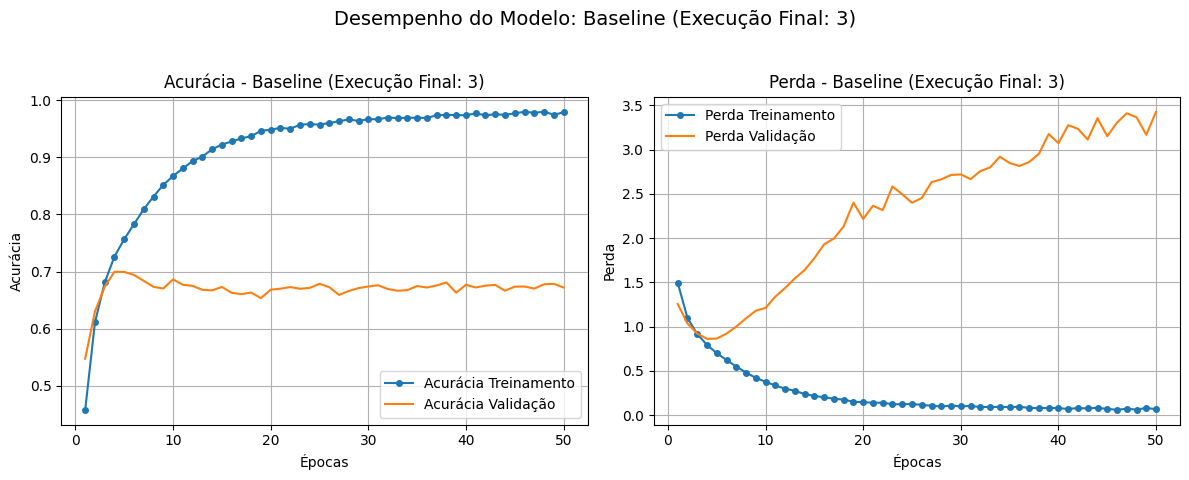

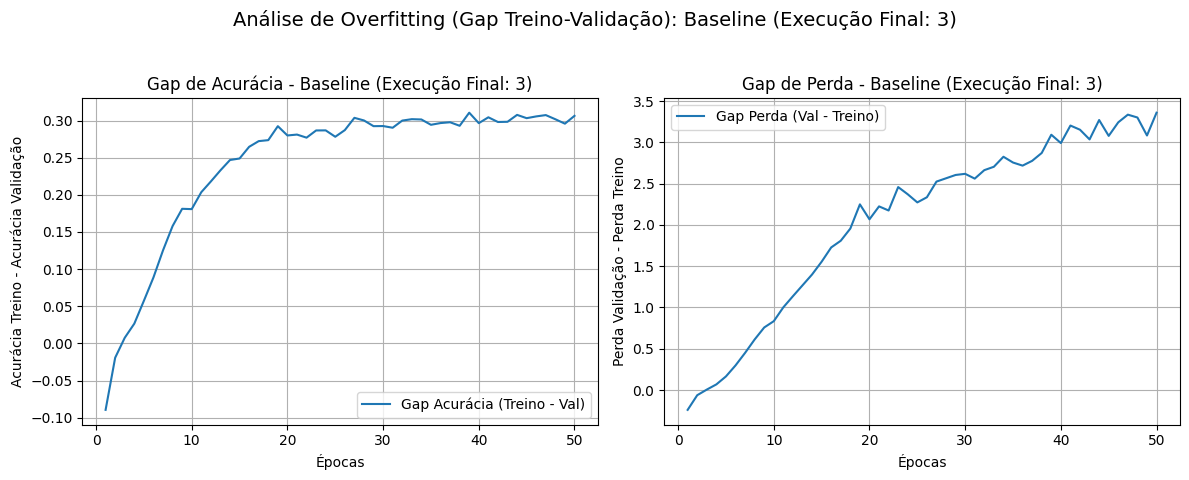

--- Treinando modelo: L1 (Run 3) ---
Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2399 - loss: 2.8667 - val_accuracy: 0.3531 - val_loss: 1.9710
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.3793 - loss: 1.9056 - val_accuracy: 0.4154 - val_loss: 1.8161
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4253 - loss: 1.7908 - val_accuracy: 0.4357 - val_loss: 1.7603
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.4486 - loss: 1.7380 - val_accuracy: 0.4548 - val_loss: 1.7164
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.4645 - loss: 1.6983 - val_accuracy: 0.4691 - val_loss: 1.6731
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4788 - loss: 1.6675 - val_accuracy: 0.4806 - val_loss: 1.6506
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.4887 - loss: 1.6439 - val_accuracy: 0.4876 - val_loss: 1.6270
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━

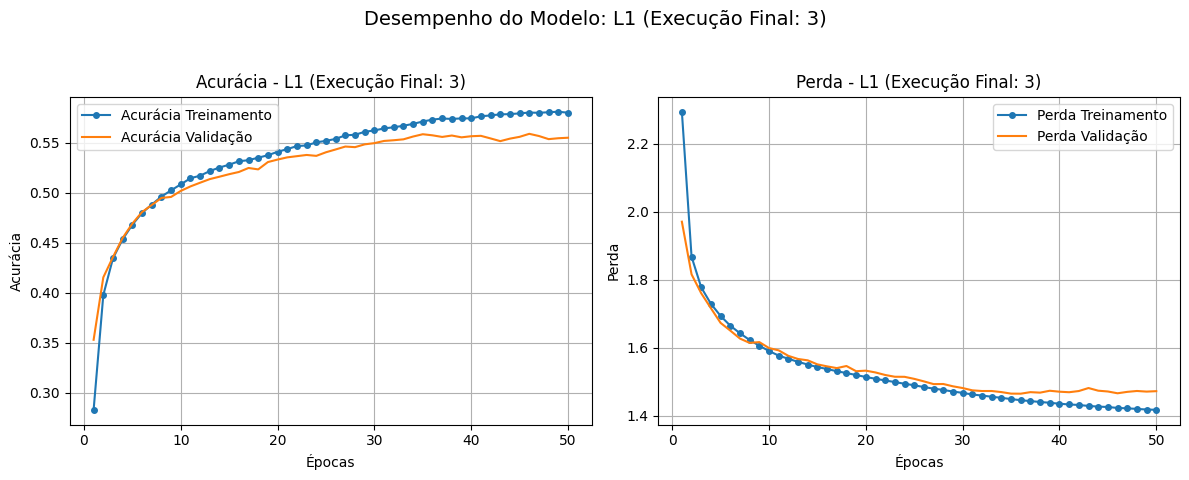

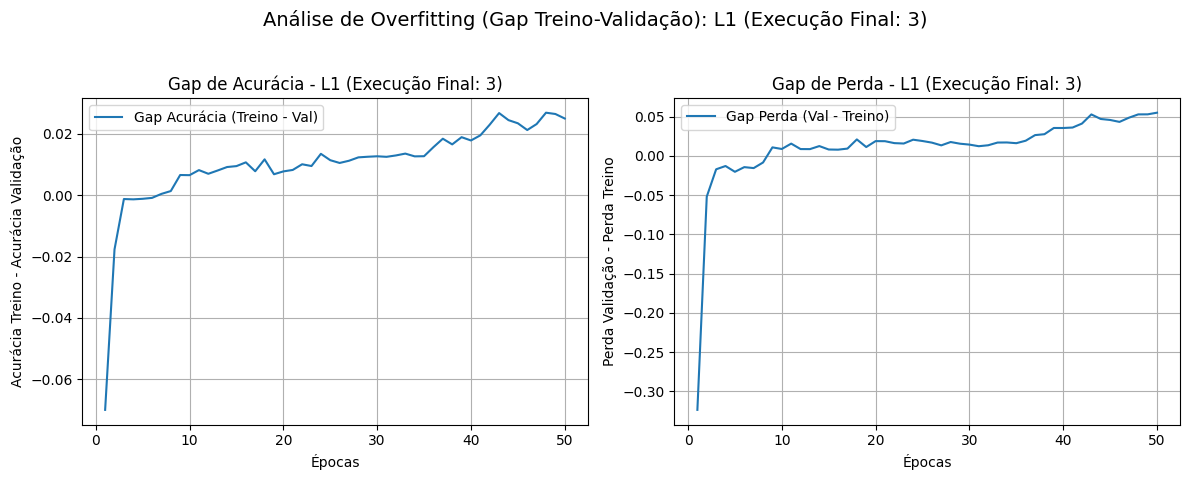

--- Treinando modelo: L2 (Run 3) ---
Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.3410 - loss: 1.8822 - val_accuracy: 0.4929 - val_loss: 1.5044
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5527 - loss: 1.3841 - val_accuracy: 0.5821 - val_loss: 1.3076
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6269 - loss: 1.2237 - val_accuracy: 0.6275 - val_loss: 1.2065
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6657 - loss: 1.1318 - val_accuracy: 0.6521 - val_loss: 1.1588
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6918 - loss: 1.0781 - val_accuracy: 0.6675 - val_loss: 1.1352
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7083 - loss: 1.0406 - val_accuracy: 0.6823 - val_loss: 1.1131
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7220 - loss: 1.0143 - val_accuracy: 0.6849 - val_loss: 1.1052
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━

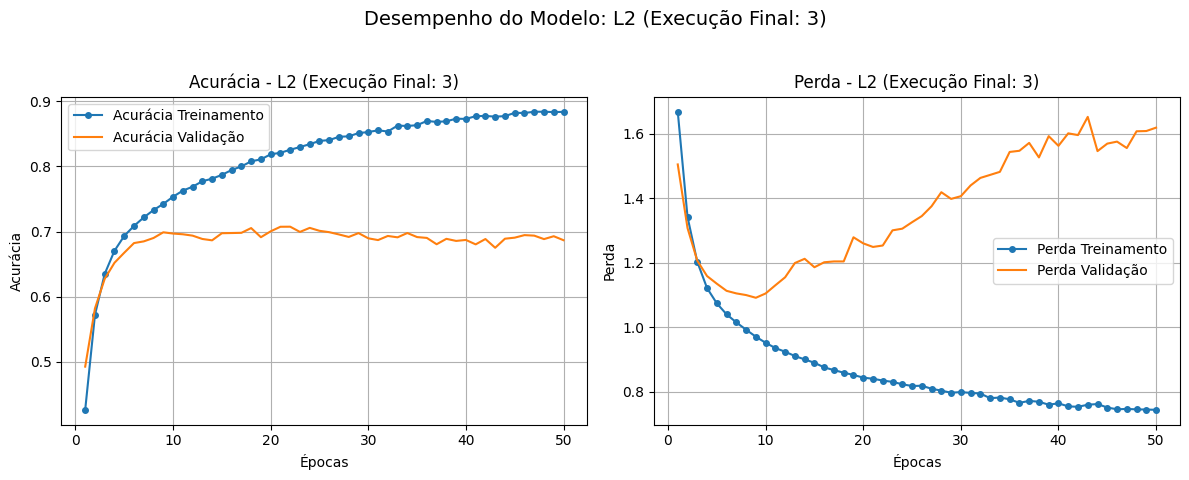

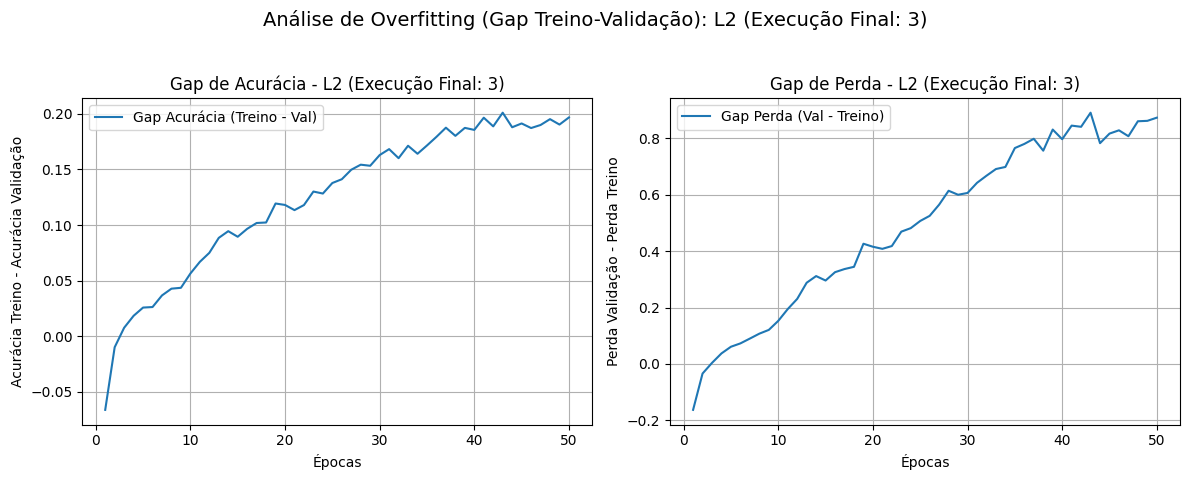

--- Treinando modelo: L1_L2 (Run 3) ---
Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.2271 - loss: 2.8319 - val_accuracy: 0.3119 - val_loss: 2.0391
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.3472 - loss: 1.9770 - val_accuracy: 0.3582 - val_loss: 1.9300
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.3822 - loss: 1.8704 - val_accuracy: 0.3910 - val_loss: 1.8505
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4043 - loss: 1.8129 - val_accuracy: 0.4041 - val_loss: 1.8000
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4194 - loss: 1.7745 - val_accuracy: 0.4152 - val_loss: 1.7618
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4309 - loss: 1.7465 - val_accuracy: 0.4241 - val_loss: 1.7469
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4377 - loss: 1.7259 - val_accuracy: 0.4320 - val_loss: 1.7272
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━

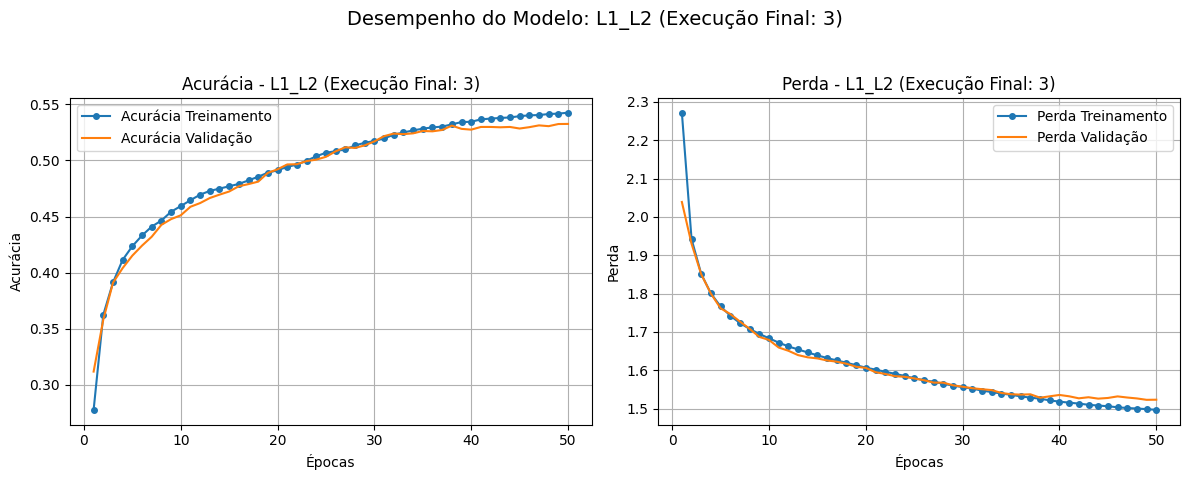

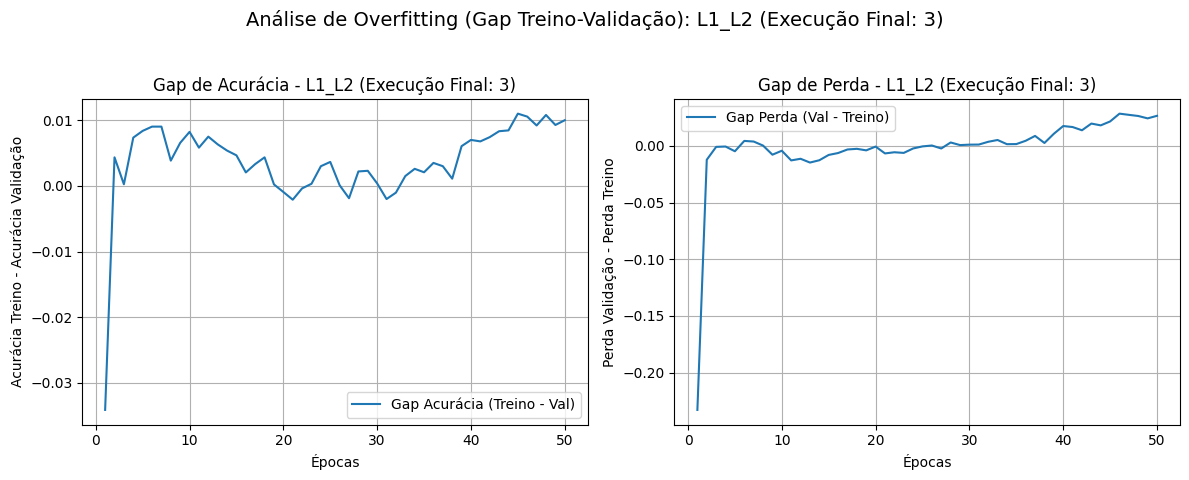

--- Treinando modelo: Dropout (Run 3) ---
Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.2562 - loss: 1.9643 - val_accuracy: 0.4830 - val_loss: 1.3943
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.4491 - loss: 1.5003 - val_accuracy: 0.5579 - val_loss: 1.2206
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5239 - loss: 1.3154 - val_accuracy: 0.6033 - val_loss: 1.1035
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5716 - loss: 1.1942 - val_accuracy: 0.6167 - val_loss: 1.0827
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6074 - loss: 1.0952 - val_accuracy: 0.6430 - val_loss: 1.0048
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6315 - loss: 1.0286 - val_accuracy: 0.6619 - val_loss: 0.9623
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6507 - loss: 0.9706 - val_accuracy: 0.6694 - val_loss: 0.9434
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━

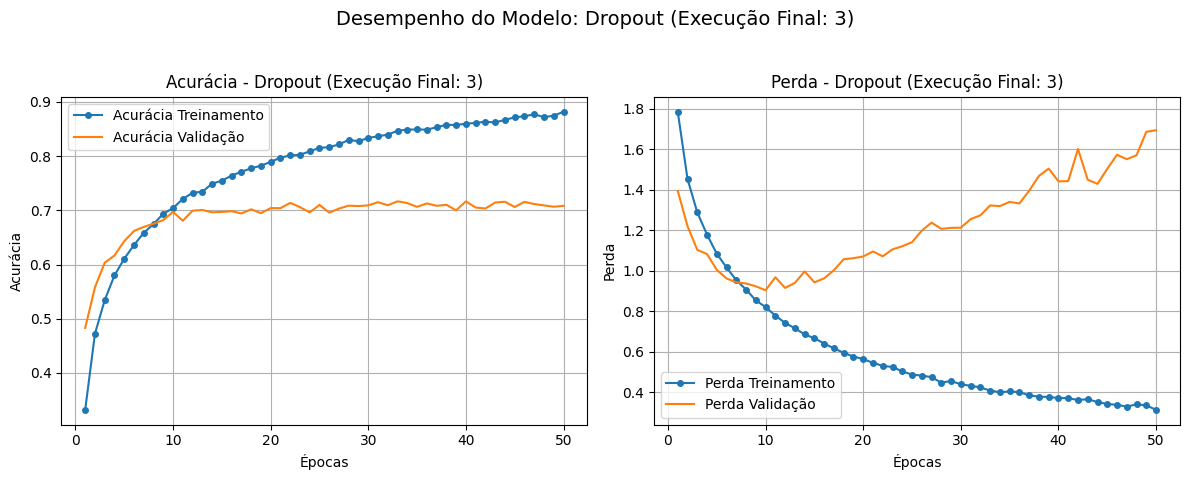

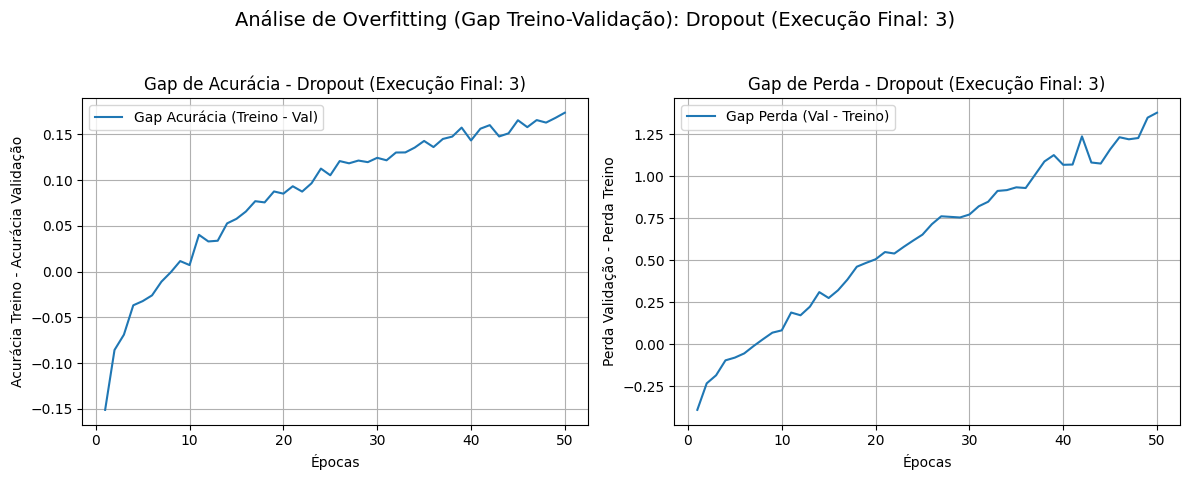

--- Treinando modelo: EarlyStopping (Run 3) ---
Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.3801 - loss: 1.6933 - val_accuracy: 0.5754 - val_loss: 1.1803
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6114 - loss: 1.1017 - val_accuracy: 0.6372 - val_loss: 1.0063
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6857 - loss: 0.9009 - val_accuracy: 0.6771 - val_loss: 0.9099
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7293 - loss: 0.7776 - val_accuracy: 0.6846 - val_loss: 0.9096
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7616 - loss: 0.6852 - val_accuracy: 0.6857 - val_loss: 0.9574
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7905 - loss: 0.6002 - val_accuracy: 0.6952 - val_loss: 0.9800
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8190 - loss: 0.5182 - val_accuracy: 0.6805 - val_loss: 1.1271
Epoch 8/50
1250/1250 ━━━━━━━

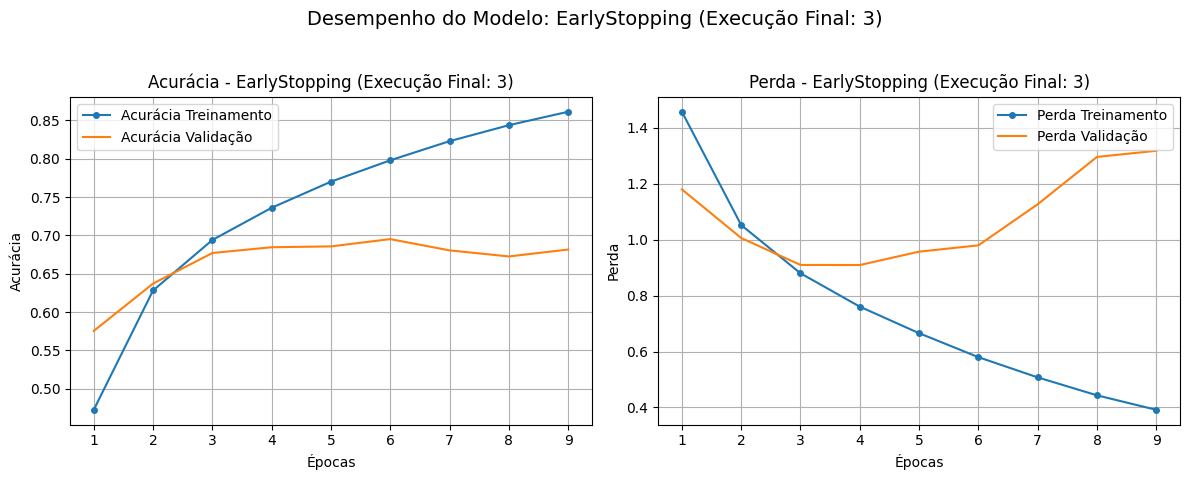

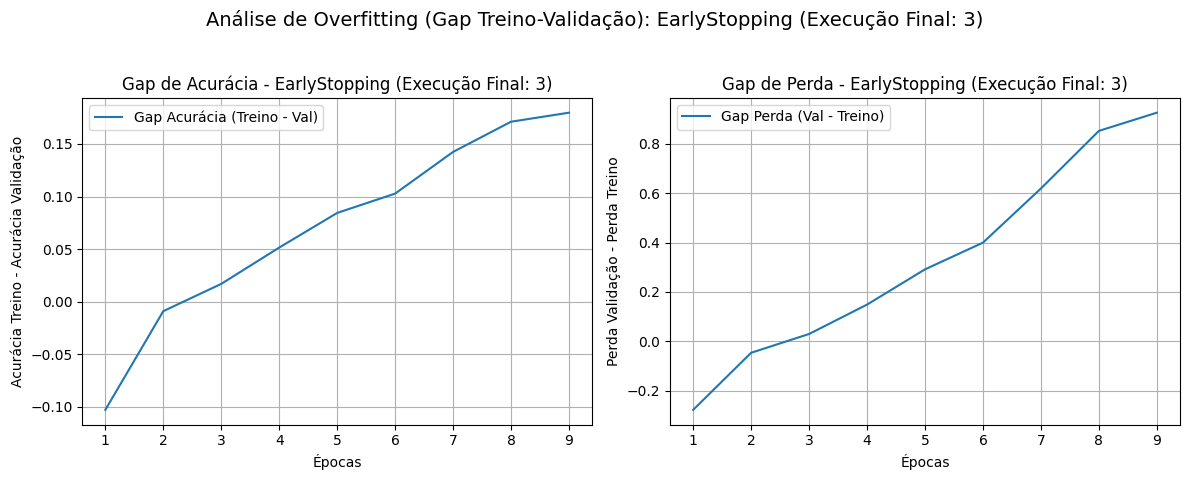

--- Treinando modelo: BatchNorm (Run 3) ---
Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - accuracy: 0.4925 - loss: 1.4236 - val_accuracy: 0.5869 - val_loss: 1.1635
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.6892 - loss: 0.8843 - val_accuracy: 0.6608 - val_loss: 0.9677
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.7553 - loss: 0.7056 - val_accuracy: 0.6172 - val_loss: 1.1524
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8062 - loss: 0.5605 - val_accuracy: 0.6167 - val_loss: 1.2571
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8547 - loss: 0.4351 - val_accuracy: 0.5786 - val_loss: 1.6763
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.8883 - loss: 0.3372 - val_accuracy: 0.6471 - val_loss: 1.3700
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.9144 - loss: 0.2616 - val_accuracy: 0.6572 - val_loss: 1.4500
Epoch 8/50
1250/1250 ━━━━━━━━━━━

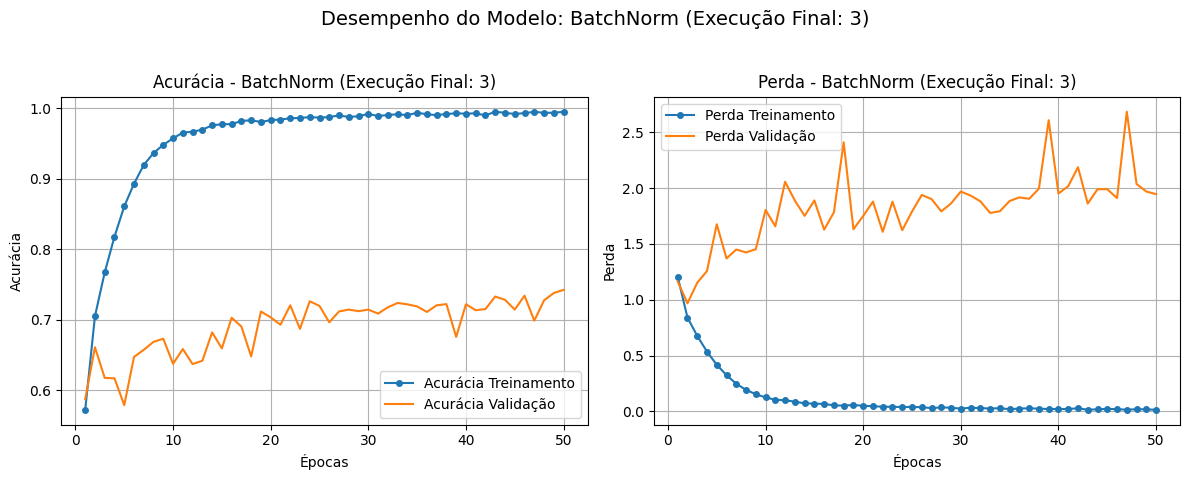

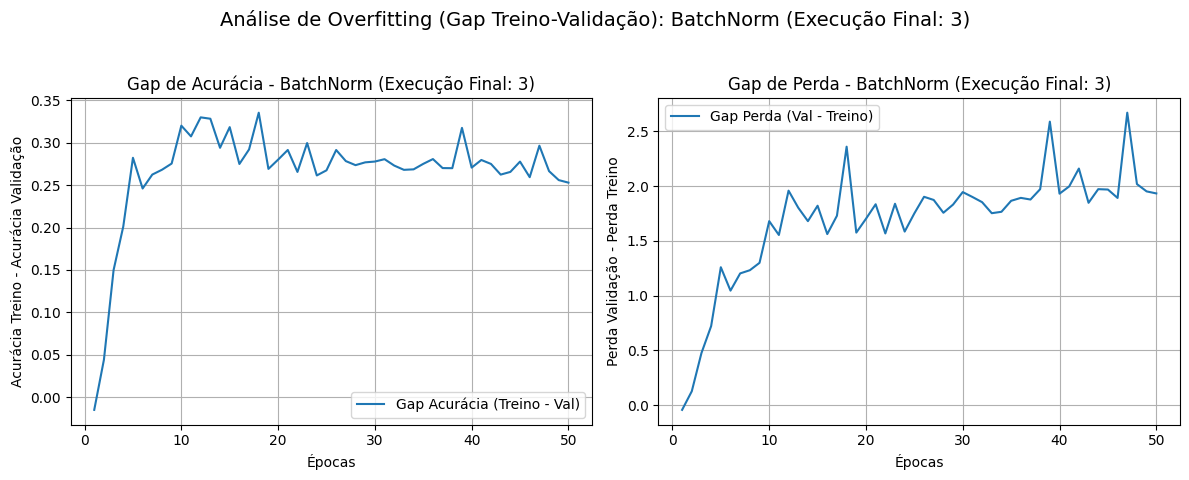

--- Treinando modelo: DataAugmentation (Run 3) ---
Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.3294 - loss: 1.8182 - val_accuracy: 0.5304 - val_loss: 1.3031
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5479 - loss: 1.2797 - val_accuracy: 0.6161 - val_loss: 1.0955
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5922 - loss: 1.1438 - val_accuracy: 0.6433 - val_loss: 1.0062
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.6282 - loss: 1.0540 - val_accuracy: 0.6685 - val_loss: 0.9546
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6519 - loss: 0.9870 - val_accuracy: 0.7008 - val_loss: 0.8588
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.6681 - loss: 0.9465 - val_accuracy: 0.7011 - val_loss: 0.8769
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6846 - loss: 0.8999 - val_accuracy: 0.7208 - val_loss: 0.8032
Epoch 8/50
1250/1250 ━━━━

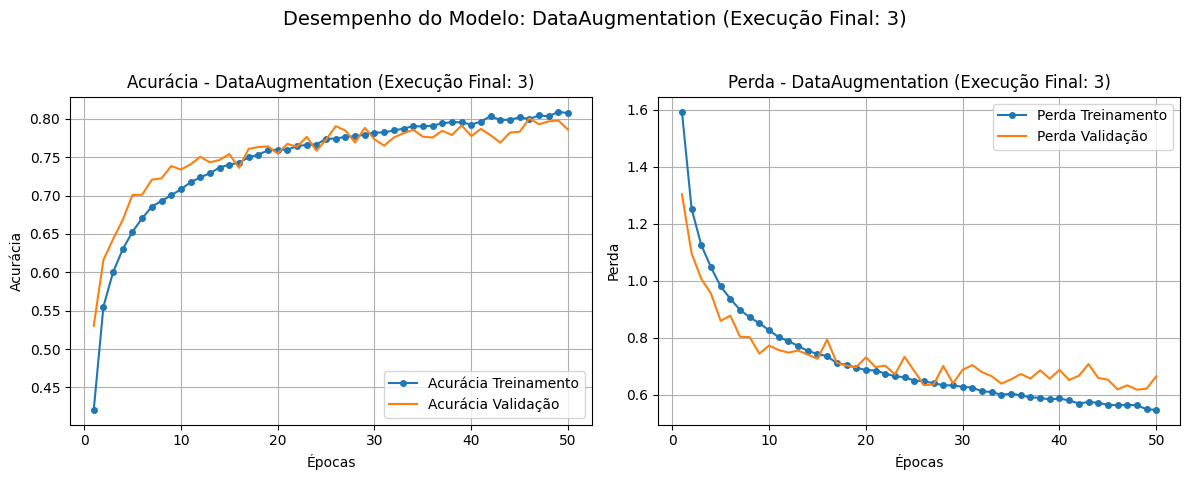

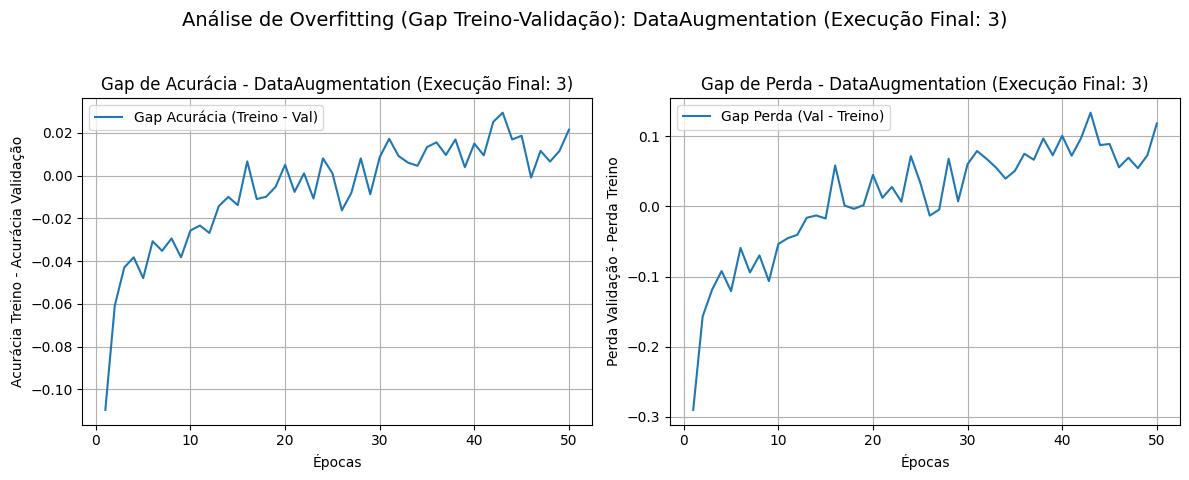

In [8]:
model_configs = {
    "Baseline": create_model_baseline,
    "L1": create_model_l1,
    "L2": create_model_l2,
    "L1_L2": create_model_l1_l2,
    "Dropout": create_model_dropout,
    "EarlyStopping": create_model_baseline,
    "BatchNorm": create_model_batch_norm,
    "DataAugmentation": create_model_baseline
}

results = {name: [] for name in model_configs.keys()}
histories_last_run = {name: None for name in model_configs.keys()}

for run in range(NUM_RUNS):
    print(f"\n--- Iniciando Execução {run + 1}/{NUM_RUNS} ---")
    seed = run
    tf.random.set_seed(seed)
    np.random.seed(seed)

    for name, model_creator in model_configs.items():
        print(f"--- Treinando modelo: {name} (Run {run + 1}) ---")
        model = model_creator()

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        run_callbacks = []
        if name == "EarlyStopping":
            early_stopping_callback = callbacks.EarlyStopping(
                monitor='val_loss',
                patience=PATIENCE,
                verbose=1,
                restore_best_weights=True
            )
            run_callbacks.append(early_stopping_callback)

        if name == "DataAugmentation":
            history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                                steps_per_epoch=len(x_train) // BATCH_SIZE,
                                epochs=EPOCHS,
                                validation_data=(x_val, y_val),
                                verbose=1,
                                callbacks=run_callbacks)
        else:
            history = model.fit(x_train, y_train,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                validation_data=(x_val, y_val),
                                verbose=1,
                                callbacks=run_callbacks)

        val_loss = history.history.get('val_loss', [])
        val_acc = history.history.get('val_accuracy', [])

        if not val_acc or not val_loss:
            print(f"Aviso: Sem dados de validação (acc/loss) para {name} na execução {run + 1}. Pulando registro de resultados.")
            best_val_acc = 0
            best_val_loss = float('inf')
            best_val_acc_epoch_index = -1
            final_epoch = len(history.epoch)
        else:
            best_val_acc_epoch_index = np.argmax(val_acc)
            best_val_acc = val_acc[best_val_acc_epoch_index]
            best_val_loss = val_loss[best_val_acc_epoch_index]
            final_epoch = len(history.epoch)

        results[name].append({
            'run': run + 1,
            'best_val_acc': best_val_acc,
            'val_loss_at_best_acc': best_val_loss,
            'best_epoch': best_val_acc_epoch_index + 1 if best_val_acc_epoch_index != -1 else 0,
            'total_epochs_ran': final_epoch
        })

        if run == NUM_RUNS - 1:
            histories_last_run[name] = history
            if val_acc and val_loss:
                plot_title = f"{name} (Execução Final: {run + 1})"
                plot_history(history, plot_title)
                plot_overfitting_gap(history, plot_title)
            else:
                print(f"Não foi possível plotar o histórico individual para {name} na execução final (dados ausentes).")

## 8. Análise Quantitativa dos Resultados (Conjunto de Validação)

In [9]:
print("\n--- Resultados Quantitativos (Conjunto de Validação) ---")
summary_data = []
for name, run_results in results.items():
    if not run_results:
        print(f"Sem resultados registrados para {name}")
        summary_data.append({
            "Técnica": name,
            f"Val Acc Média (±std)": "N/A",
            f"Melhor Época Média (±std)": "N/A",
            f"Épocas Totais Média (±std)": "N/A"
        })
        continue

    best_val_accs = [r['best_val_acc'] for r in run_results]
    best_epochs = [r['best_epoch'] for r in run_results if r['best_epoch'] > 0]
    total_epochs = [r['total_epochs_ran'] for r in run_results]

    mean_best_val_acc = np.mean(best_val_accs)
    std_best_val_acc = np.std(best_val_accs)

    mean_best_epoch = np.mean(best_epochs) if best_epochs else 0
    std_best_epoch = np.std(best_epochs) if best_epochs else 0

    mean_total_epochs = np.mean(total_epochs)
    std_total_epochs = np.std(total_epochs)

    summary_data.append({
        "Técnica": name,
        f"Val Acc Média (±std)": f"{mean_best_val_acc:.4f} ± {std_best_val_acc:.4f}",
        f"Melhor Época Média (±std)": f"{mean_best_epoch:.1f} ± {std_best_epoch:.1f}" if best_epochs else "N/A",
        f"Épocas Totais Média (±std)": f"{mean_total_epochs:.1f} ± {std_total_epochs:.1f}"
    })

summary_df = pd.DataFrame(summary_data)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(summary_df.to_string(index=False))


--- Resultados Quantitativos (Conjunto de Validação) ---
         Técnica Val Acc Média (±std) Melhor Época Média (±std) Épocas Totais Média (±std)
        Baseline      0.6935 ± 0.0074                 4.7 ± 0.5                 50.0 ± 0.0
              L1      0.5444 ± 0.0109                48.0 ± 1.4                 50.0 ± 0.0
              L2      0.7108 ± 0.0095               28.7 ± 14.7                 50.0 ± 0.0
           L1_L2      0.5264 ± 0.0076                49.3 ± 0.9                 50.0 ± 0.0
         Dropout      0.7187 ± 0.0016                27.7 ± 7.5                 50.0 ± 0.0
   EarlyStopping      0.7000 ± 0.0050                 5.0 ± 0.8                  9.0 ± 0.8
       BatchNorm      0.7348 ± 0.0056                42.7 ± 5.2                 50.0 ± 0.0
DataAugmentation      0.8001 ± 0.0009                46.7 ± 0.9                 50.0 ± 0.0


## 9. Comparação Visual (Apenas da Última Execução)


--- Comparação Visual (Última Execução) ---


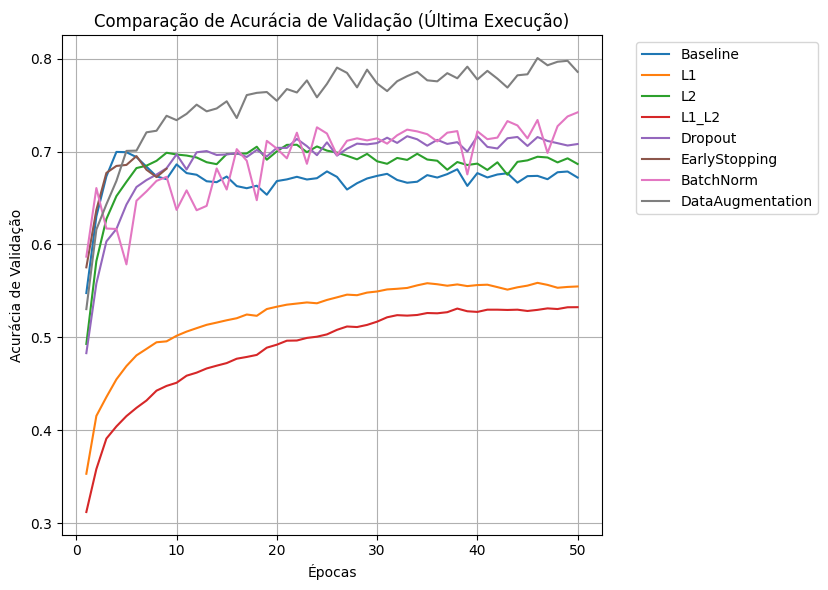

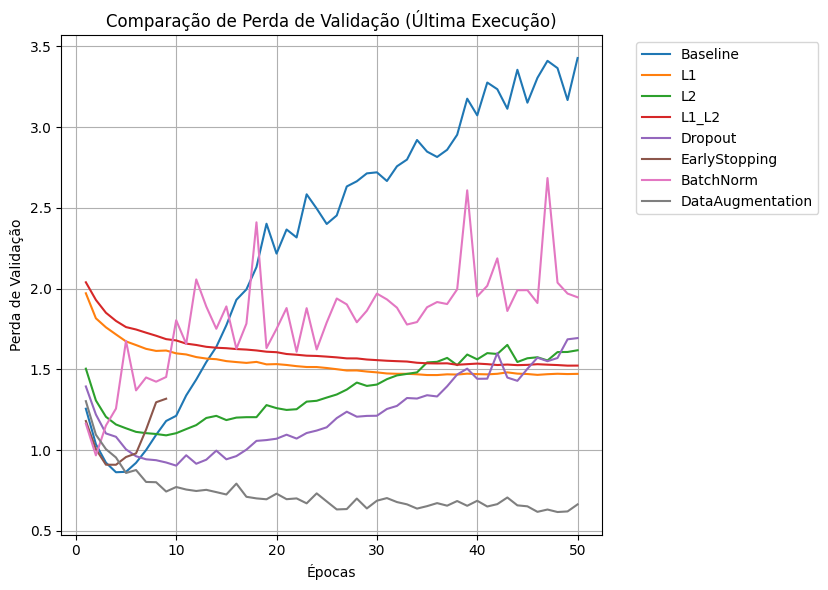

In [10]:
print("\n--- Comparação Visual (Última Execução) ---")
if any(hist is not None for hist in histories_last_run.values()):
    compare_histories(histories_last_run)
    compare_validation_loss(histories_last_run)
else:
    print("Nenhum histórico da última execução disponível para comparação visual.")

## 10. Avaliação Final no Conjunto de Teste

In [11]:
print(f"\n--- Avaliação Final no Conjunto de Teste ---")

acc_column_name = "Val Acc Média (±std)"

def extract_mean_acc(acc_str):
    if isinstance(acc_str, str) and "±" in acc_str:
        return float(acc_str.split(' ± ')[0])
    return -1.0

summary_df['MeanAcc'] = summary_df[acc_column_name].apply(extract_mean_acc)

if summary_df['MeanAcc'].max() == -1.0:
    print("ERRO: Não foi possível determinar o melhor modelo. Nenhuma acurácia média válida encontrada.")
    best_model_name = "Nenhum (Erro na Análise)"
    can_evaluate_best_model = False
else:
    best_model_name = summary_df.loc[summary_df['MeanAcc'].idxmax()]["Técnica"]
    print(f"Melhor modelo com base na acurácia média de validação: {best_model_name}")
    can_evaluate_best_model = True


--- Avaliação Final no Conjunto de Teste ---
Melhor modelo com base na acurácia média de validação: DataAugmentation


### 10.1 Avaliação do Modelo Baseline no Teste

In [12]:
print("\nRe-treinando e avaliando Baseline no Conjunto de Teste...")
final_seed_base = NUM_RUNS * 10
tf.random.set_seed(final_seed_base)
np.random.seed(final_seed_base)

model_baseline_final = create_model_baseline()

optimizer_base_final = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model_baseline_final.compile(optimizer=optimizer_base_final,
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                             metrics=['accuracy'])

baseline_epochs_avg = EPOCHS
if 'Baseline' in results and results['Baseline']:
    valid_epochs = [r['best_epoch'] for r in results['Baseline'] if r['best_epoch'] > 0]
    if valid_epochs:
        baseline_epochs_avg = int(round(np.mean(valid_epochs)))
    else:
        print("Aviso: Baseline não teve 'melhor época' válida nas runs. Usando default de épocas.")

baseline_epochs_avg = max(1, baseline_epochs_avg)

print(f"Treinando baseline por {baseline_epochs_avg} épocas no conjunto completo de treino+validação...")

history_baseline_final = model_baseline_final.fit(x_train_full, y_train_full,
                                                epochs=baseline_epochs_avg,
                                                batch_size=BATCH_SIZE,
                                                verbose=0)

print("Avaliando Baseline no conjunto de teste...")
test_loss_base, test_acc_base = model_baseline_final.evaluate(x_test, y_test, verbose=2)
print(f"-> Acurácia Final do Baseline no Teste: {test_acc_base:.4f}")


Re-treinando e avaliando Baseline no Conjunto de Teste...
Treinando baseline por 5 épocas no conjunto completo de treino+validação...


c:\Users\rioslp\OneDrive - Alcoa Corporation\Documents\Pessoal\Estágio\Código - TCC\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Avaliando Baseline no conjunto de teste...
313/313 - 2s - 6ms/step - accuracy: 0.7053 - loss: 0.8684
-> Acurácia Final do Baseline no Teste: 0.7053


### 10.2 Avaliação do Melhor Modelo no Teste

In [13]:
if can_evaluate_best_model and best_model_name in model_configs:
    print(f"\nRe-treinando e avaliando Melhor Modelo ({best_model_name}) no Conjunto de Teste...")
    final_seed_best = NUM_RUNS * 10 + 1
    tf.random.set_seed(final_seed_best)
    np.random.seed(final_seed_best)

    best_model_creator = model_configs[best_model_name]
    model_best_final = best_model_creator()

    optimizer_best_final = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    model_best_final.compile(optimizer=optimizer_best_final,
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])

    best_model_epochs_avg = EPOCHS
    if best_model_name in results and results[best_model_name]:
        valid_epochs_best = [r['best_epoch'] for r in results[best_model_name] if r['best_epoch'] > 0]
        if valid_epochs_best:
            best_model_epochs_avg = int(round(np.mean(valid_epochs_best)))
        else:
            print(f"Aviso: {best_model_name} não teve 'melhor época' válida nas runs. Usando default de épocas.")

    best_model_epochs_avg = max(1, best_model_epochs_avg)

    print(f"Treinando {best_model_name} por {best_model_epochs_avg} épocas no conjunto completo de treino+validação...")

    final_callbacks = []

    if best_model_name == "DataAugmentation":
        datagen_final = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1
        )
        print(f"Usando Data Augmentation para o treino final de {best_model_name}.")
        history_best_final = model_best_final.fit(datagen_final.flow(x_train_full, y_train_full, batch_size=BATCH_SIZE),
                                                    steps_per_epoch=len(x_train_full) // BATCH_SIZE,
                                                    epochs=best_model_epochs_avg,
                                                    verbose=0,
                                                    callbacks=final_callbacks)
    else:
        history_best_final = model_best_final.fit(x_train_full, y_train_full,
                                                    epochs=best_model_epochs_avg,
                                                    batch_size=BATCH_SIZE,
                                                    verbose=0,
                                                    callbacks=final_callbacks)

    print(f"Avaliando {best_model_name} no conjunto de teste...")
    test_loss_best, test_acc_best = model_best_final.evaluate(x_test, y_test, verbose=2)
    print(f"-> Acurácia Final do {best_model_name} no Teste: {test_acc_best:.4f}")

elif not can_evaluate_best_model:
    print("\nAvaliação do melhor modelo pulada devido a erro na determinação do melhor modelo.")
else:
    print(f"\nAvaliação do melhor modelo ({best_model_name}) pulada (modelo não encontrado nas configurações?).")


Re-treinando e avaliando Melhor Modelo (DataAugmentation) no Conjunto de Teste...
Treinando DataAugmentation por 47 épocas no conjunto completo de treino+validação...
Usando Data Augmentation para o treino final de DataAugmentation.


c:\Users\rioslp\OneDrive - Alcoa Corporation\Documents\Pessoal\Estágio\Código - TCC\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\rioslp\OneDrive - Alcoa Corporation\Documents\Pessoal\Estágio\Código - TCC\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Avaliando DataAugmentation no conjunto de teste...
313/313 - 2s - 6ms/step - accuracy: 0.7522 - loss: 0.7417
-> Acurácia Final do DataAugmentation no Teste: 0.7522
